### SI Model

In this file, we will model a Susceptible-Infected (SI) model with demographics.

The equations we use are as follows:

\begin{align*}
\dot{S_j} &= b(t)S_f - S_j(\beta_j I_f + \gamma N + m + \mu)\\
\dot{S_v} &= m S_j + v(t) S_f - S_v(\beta_v  I_f + f(t) + \mu)\\
\dot{S_f} &= f(t) S_v - S_f(\beta_f I_f + v(t) + \mu)\\
\dot{I_j} &= \beta_j S_j I_f - I_j(m + \mu)\\
\dot{I_v} &= m I_j + \beta_v S_v I_f  + v(t)I_f - I_v(f(t) + \mu)\\
\dot{I_f} &= f(t) I_v + I_f(\beta_f S_f - v(t) - \mu) 
\end{align*}

$Sj$ = Susceptible Juveniles
$Sv$ = Susceptible Vegetatives
$Sf$ = Susceptible Flowering
$Ij$ = Infected Juveniles
$Iv$ = Infected Vegetatives
$If$ = Infected Flowering

Other variables are defined in the code block below.

This code below implements a numerical solution to this model. To run this code, we will use the numpy package for handling arrays, the solve_ivp function from scipy to handle the numerical solving, and matplotlib for plotting.

In [36]:
import numpy as np
import math

from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from matplotlib import pyplot as plt

First, we define a few values needed to run the simulation.
First we define the initial conditions with `X_0`.
This describes the starting number for each of our six compartments.
For systems with a global attractor (a single globally stable equilibrium), the initials conditions do not matter for the final equilibirum, but this is not the case for our SIR model.

Next, we define a variable `t`, which is a tuple with two values.
The first value is the initial time point and the second is the final time point.
This tells the numerical solver the time range over which to produce a solution.

Finally, we set values for our simulation parameters and some helper functions.

In [37]:
X_0 = (30, 0, 0, 15, 0, 0) #Initial population size, represents: 
#Susceptible Juveniles, Susceptible Vegetatives, Susceptible Flowerings, Infected Juveniles, Infected Vegetatives, Infected Flowerings
t = (0, 365*2) #Time range for the system

#CONSTANTS
Bj=.005 #betaj, Juvenile Transmission Rate
Bv=.0005 #betav, Vegetative Transmission Rate
Bf=.002 #betaf, Flowering Transmission Rate
theta = 0.01 #theta, Density Dependent Population Control
death = 0.025 #mu, Death Rate
maturity=.3 #m, Maturity Rate
#Flowering and Vegetative Curves
shift=220 #Shift between susceptible and infected curves
base=.08 #Average flowering and vegetating value
stretch=40 #Period of curve, 80 pi
amp=.08 #Amplitude of curve

#Helper functions for model
#Birth pulse function
def birth(t):
    #BIRTH PARAMETERS: CUSTOMIZABLE
    start=5 #Birth pulse start time
    end=6 #Birth pulse end time
    low=.8 #Lowest possible birth rate
    high=.8 #Highest possible birth rate

    #Oscillating function for birth rate
    time=t%365
    tmid=(start+end)/2
    mid=(high-low)/2
    if(time<tmid): 
        x=mid*np.tanh(time-start)+mid+low
    else:
        x=mid*np.tanh(-(time-end))+mid+low
    return x


#Flowering and Vegetating functions
#Susceptible functions
def floweringS(t):
    return amp*np.sin(t/stretch)+base

def vegetatingS(t):
    return amp*np.cos(t/stretch-1.5*np.pi)+base

#Infected functions, includes time shift between susceptible functions
def floweringI(t):
    return amp*np.sin((t-shift)/stretch)+base

def vegetatingI(t):
    return amp*np.cos((t-shift)/stretch-1.5*np.pi)+base

#Helper method to actually solve the model with set of differential equations
def SI(t, X, Bj, Bv, Bf, theta, death, maturity):
    #Unpack the tuple containing the values for S, I, and R
    Sj, Sv, Sf, Ij, Iv, If = X

    dSj=birth(t)*Sf-Bj*Sj*If-theta*Sj*(Sv+Sf+Iv+If)-maturity*Sj-death*Sj
    dSv=maturity*Sj-Bv*Sv*If-floweringS(t)*Sv+vegetatingS(t)*Sf-death*Sv
    dSf=floweringS(t)*Sv-Bf*Sf*If-vegetatingS(t)*Sf-death*Sf
    dIj=Bj*Sj*If-maturity*Ij-death*Ij
    dIv=maturity*Ij+Bv*Sv*If-floweringI(t)*Iv+vegetatingI(t)*If-death*Iv
    dIf=floweringI(t)*Iv+Bf*Sf*If-vegetatingI(t)*If-death*If

    return (dSj, dSv, dSf, dIj, dIv, dIf)

Now we are ready to compute our solution. To do this, we use the `solve_ivp` function from scipy.
This takes in several paramters:
1. The function that returns the differentials (SIR)
2. The time range to compute the solution
3. The initial conditions
4. A tuple of parameters

We have also defined an addition keyword argument, `max_step`, which is not strictly necesary, but can be used to produce smoother results.
The `solve_ivp` function returns a class structure which has several important attributes:
- solution.y: a matrix of results where the rows are the compartments and the columns are the time points
- solution.t: the time points at which the solution is calcuated (depending on the algorithm, they may not be evenly spaced)

In [38]:
#Run the solve_ivp function to get a numerical solution
solution = solve_ivp(SI, t, X_0, args=(Bj, Bv, Bf, theta, death, maturity), max_step=0.1)

Sj = solution.y[0, :]
Sv = solution.y[1, :]
Sf = solution.y[2, :]
Ij = solution.y[3, :]
Iv = solution.y[4, :]
If = solution.y[5, :]

time_points = solution.t

class1 = Ij
class2 = Sj

#Solve for optimal pathogen evolution, in which the set width of the juvenile transmission peak slides through the entire t=0 to t=3650. 
max1=-math.inf
min1=math.inf
max2=-math.inf
min2=math.inf
print("first time: "+str(time_points[int(len(class1)*.8)]))
for temp_t in range(int(len(class1)*.8), int(len(class1))):
    # print("min1="+str(min1)+", time="+str(time_points[temp_t]))
    if(class1[temp_t]>max1):
        max1=class1[temp_t]
    elif(class1[temp_t]<min1):
        # print("bye")
        min1=class1[temp_t]
    if(class2[temp_t]>max2):
        max2=class2[temp_t]
    elif(class2[temp_t]<min2):
        min2=class2[temp_t]
final1=(max1+min1)/2
final2=(max2+min2)/2

# final = integrate.simps(class1, x=solution.t, axis=-1, even='avg')/(integrate.simps(class1, x=solution.t, axis=-1, even='avg')+integrate.simps(class2, x=solution.t, axis=-1, even='avg'))
totIj=integrate.simps(class1, x=solution.t, axis=-1, even='avg')
totSj=integrate.simps(class2, x=solution.t, axis=-1, even='avg')
toPrint=totIj/(totIj+totSj)
delta=final1-final2
# print("Solution length: "+str(len(temp_solution.y[1,:]))+"and"+str(len(temp_solution.y[3,:])))
#The graphed value is the final proportion of susceptible adults out of all adult plants, effectively seeing how successful the virus was
proportion=final1/(final1+final2)
print("Current total: "+str(toPrint)+". Total Ij: "+str(totIj)+". Total Sj: "+str(totSj)+"")

first time: 584.0155997898552
Current total: 0.2920953414992433. Total Ij: 1167.9785184957564. Total Sj: 2830.6423170877583


/var/folders/jk/jjsz169j635_4flxb1lg15cm0000gn/T/ipykernel_27667/4017940071.py:37: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  totIj=integrate.simps(class1, x=solution.t, axis=-1, even='avg')
/var/folders/jk/jjsz169j635_4flxb1lg15cm0000gn/T/ipykernel_27667/4017940071.py:38: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  totSj=integrate.simps(class2, x=solution.t, axis=-1, even='avg')


Finally, we can graph the solution and other supplemental graphs using the matplotlib package.

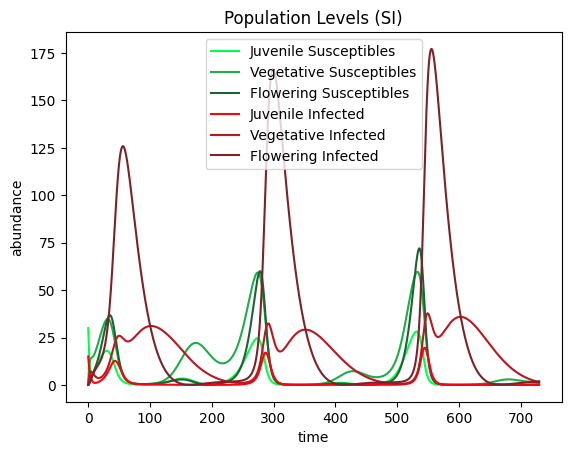

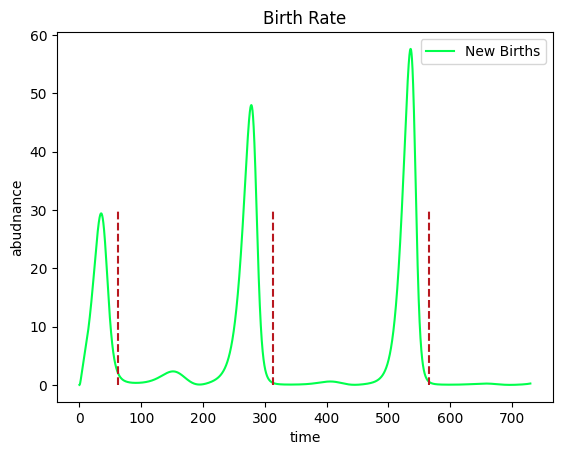

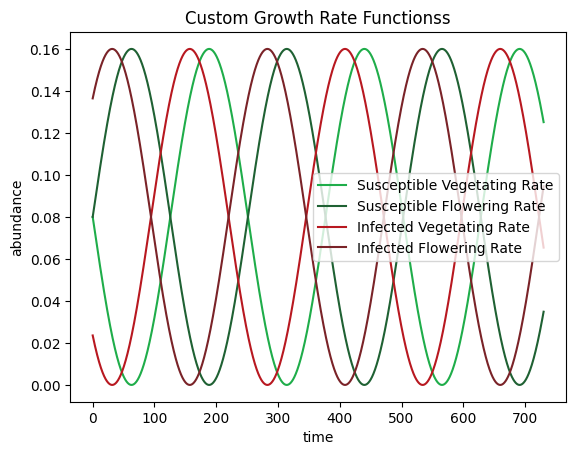

In [39]:
colSj='#00ff4c'
colSv='#1fad4a'
colSf='#1f6133'
colIj='#ff000d'
colIv='#b81820'
colIf='#7a2328'
colTot='#245bd1'

#The first graph represents the population levels of each demographic accross the timescale
fig, populationGraph = plt.subplots()
populationGraph.set_title('Population Levels (SI)')
populationGraph.plot(time_points, Sj, label='Juvenile Susceptibles', color=colSj)
populationGraph.plot(time_points, Sv, label='Vegetative Susceptibles', color=colSv)
populationGraph.plot(time_points, Sf, label='Flowering Susceptibles', color=colSf)
populationGraph.plot(time_points, Ij, label='Juvenile Infected', color=colIj)
populationGraph.plot(time_points, Iv, label='Vegetative Infected', color=colIv)
populationGraph.plot(time_points, If, label='Flowering Infected', color=colIf)
# populationGraph.plot(time_points, Sj+Sa+Ij+Ia, label='Total', color=colTot)
# populationGraph.plot((startJ, startJ+.000000001), (0, max(Sa)), '--', color=colIj)
# populationGraph.plot((endJ, endJ+.000000001), (0, 100), '--', color=colIj)
# populationGraph.plot((startA, startA+.000000001), (0, max(Sa)), '--', color=colIa)
# populationGraph.plot((endA, endA+.000000001), (0, 150), '--', color=colIa)
populationGraph.set_xlabel('time')
populationGraph.set_ylabel('abundance')
populationGraph.legend()

# The second graph represents the current birth pulse function
peak1=(stretch*np.pi)/2
peak2=peak1+2*np.pi*stretch
peak3=peak2+2*np.pi*stretch
fig, custom = plt.subplots()
custom.set_title('Birth Rate')
custom.plot(time_points, birthVector(time_points)*Sf, label='New Births', color=colSj)
custom.plot((peak1, peak1+.000000001),(0,30),'--', color=colIv)
custom.plot((peak2, peak2+.000000001),(0,30),'--', color=colIv)
custom.plot((peak3, peak3+.000000001),(0,30),'--', color=colIv)
custom.plot()
custom.set_xlabel('time')
custom.set_ylabel('abudnance')
custom.legend()

#The third graph represenents both tramission pulse functions
fig, custom2 = plt.subplots()
custom2.set_title('Custom Growth Rate Functionss')
custom2.plot(time_points, vegetatingS(time_points), label='Susceptible Vegetating Rate', color=colSv)
custom2.plot(time_points, floweringS(time_points), label='Susceptible Flowering Rate', color=colSf)
custom2.plot(time_points, vegetatingI(time_points), label='Infected Vegetating Rate', color=colIv)
custom2.plot(time_points, floweringI(time_points), label='Infected Flowering Rate', color=colIf)
custom2.plot()
custom2.set_xlabel('time')
custom2.set_ylabel('abundance')
custom2.legend()

#The fourth graph represents the optimization points of the pathogen, showing how successful was if the pathogen peak started at that t value
# fig, pathogenEvolution = plt.subplots()
# pathogenEvolution.set_title('Pathogen Evolution Optimization')
# pathogenEvolution.plot(short_time, proportions, label='Susceptible Adults - Infected Adults', color=colTot)
# # pathogenEvolution.plot((startJ, startJ+.000000001), (0, 100), '--', color=colIj)
# pathogenEvolution.plot((startA, startA+.000000001), (0, max(proportions)), '--', color=colIj, label='Adult Pulse Beginning')
# pathogenEvolution.plot()
# pathogenEvolution.set_xlabel('time')
# pathogenEvolution.set_ylabel('proportion')
# pathogenEvolution.legend()
